## [WNN analysis of CITE-seq, RNA + ADT](https://satijalab.org/seurat/articles/weighted_nearest_neighbor_analysis.html)

Seurat uses the CITE-seq dataset from ([Stuart*, Butler* et al, Cell 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8)), which consists of 30,672 scRNA-seq profiles measured alongside a panel of 25 antibodies from bone marrow. The object contains two assays, RNA and antibody-derived tags (ADT).

### Installing required libraries

In [1]:
library(devtools)

Loading required package: usethis



Setting custom value for environment variable `R_LIBS_USER`

In [2]:
Sys.setenv(R_LIBS_USER = "/home/vmuser/miniconda3/envs/notebook-env/lib/R/library")

Install `SeuratData` package

In [3]:
devtools::install_github('satijalab/seurat-data',force=TRUE)


v  checking for file '/home/vmuser/.tmp/RtmpZ1kc63/remotesf702f51b876/satijalab-seurat-data-c633765/DESCRIPTION' (612ms)
-  preparing 'SeuratData':
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts
-  checking for empty or unneeded directories
-  building 'SeuratData_0.2.1.tar.gz'
   


In [4]:
library(Seurat)
library(SeuratData)
library(cowplot)
library(dplyr)

Registered S3 method overwritten by 'spatstat':
  method     from
  print.boxx cli 

Attaching SeuratObject

-- Installed datasets ------------------------------------- SeuratData v0.2.1 --

v bmcite 0.3.0                          


-------------------------------------- Key -------------------------------------

v Dataset loaded successfully
> Dataset built with a newer version of Seurat than installed
(?) Unknown version of Seurat installed



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [5]:
InstallData("bmcite")

Warning message:
"The following packages are already installed and will not be reinstalled: bmcite"


In [6]:
bm <- LoadData(ds = "bmcite")

We first perform pre-processing and dimensional reduction on both assays independently. We use standard normalization, but you can also use SCTransform or any alternative method.

In [7]:
DefaultAssay(bm) <- 'RNA'
bm <- NormalizeData(bm) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA()

DefaultAssay(bm) <- 'ADT'
# we will use all ADT features for dimensional reduction
# we set a dimensional reduction name to avoid overwriting the 
VariableFeatures(bm) <- rownames(bm[["ADT"]])
bm <- NormalizeData(bm, normalization.method = 'CLR', margin = 2) %>% 
  ScaleData() %>% RunPCA(reduction.name = 'apca')

Centering and scaling data matrix

PC_ 1 
Positive:  TRBC1, LAT, CD8B, CCL5, KLRB1, IGKC, S100A12, GZMA, S100A8, S100A9 
	   MS4A1, S100B, GNLY, CST7, TYROBP, KLRD1, RP11-291B21.2, NKG7, VCAN, CD14 
	   IGLC2, CCL4, AC092580.4, FCN1, IGLC3, PRF1, RBP7, SERPINA1, DUSP2, JUN 
Negative:  KIAA0101, TYMS, KLF1, KCNH2, FAM178B, APOC1, CNRIP1, CENPU, GATA1, BIRC5 
	   CENPF, EPCAM, CKS2, RP11-620J15.3, TUBA1B, TFR2, CA1, HMGA1, STMN1, HIST1H4C 
	   CDT1, AHSP, TOP2A, TK1, GFI1B, TUBB, MKI67, NME4, SMIM1, TMEM56 
PC_ 2 
Positive:  RPL3, RPS3, RPS18, RPS5, RPS4X, RPSA, RPS12, RPS23, RPS2, EEF1B2 
	   RPL4, LDHB, NPM1, RPS17, RPLP0, TRBC1, LAT, RPL7A, GYPC, HSPA8 
	   CD8B, KLRB1, CCL5, HNRNPA1, PEBP1, RPL37A, MYC, NUCB2, SOD1, CD79A 
Negative:  LYZ, FCN1, CST3, TYROBP, S100A9, LST1, S100A8, CSTA, MNDA, VCAN 
	   LGALS1, AIF1, S100A12, CFD, SERPINA1, FCER1G, MS4A6A, FOS, S100A6, CD14 
	   LGALS2, FTH1, GAPDH, ANXA2, CD36, CPVL, RBP7, HLA-DRA, LINC01272, H3F3A 
PC_ 3 
Positive:  CD74, HLA-DRA, HL

For each cell, we calculate its closest neighbors in the dataset based on a weighted combination of RNA and protein similarities. The cell-specific modality weights and multimodal neighbors are calculated in a single function, which takes ~2 minutes to run on this dataset. We specify the dimensionality of each modality (similar to specifying the number of PCs to include in scRNA-seq clustering), but you can vary these settings to see that small changes have minimal effect on the overall results.

In [8]:
# Identify multimodal neighbors. These will be stored in the neighbors slot, 
# and can be accessed using bm[['weighted.nn']]
# The WNN graph can be accessed at bm[["wknn"]], 
# and the SNN graph used for clustering at bm[["wsnn"]]
# Cell-specific modality weights can be accessed at bm$RNA.weight
bm <- FindMultiModalNeighbors(
  bm, reduction.list = list("pca", "apca"), 
  dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Warning message in FindMultiModalNeighbors(bm, reduction.list = list("pca", "apca"), :
"The number of provided modality.weight.name is not equal to the number of modalities. RNA.weight ADT.weight are used to store the modality weights"
Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



We can now use these results for downstream analysis, such as visualization and clustering. For example, we can create a UMAP visualization of the data based on a weighted combination of RNA and protein data We can also perform graph-based clustering and visualize these results on the UMAP, alongside a set of cell annotations.

In [9]:
bm <- RunUMAP(bm, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
bm <- FindClusters(bm, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:12:49 UMAP embedding parameters a = 0.9922 b = 1.112

12:12:50 Commencing smooth kNN distance calibration using 1 thread

12:12:51 Initializing from normalized Laplacian + noise

12:12:53 Commencing optimization for 200 epochs, with 983534 positive edges

12:13:57 Optimization finished



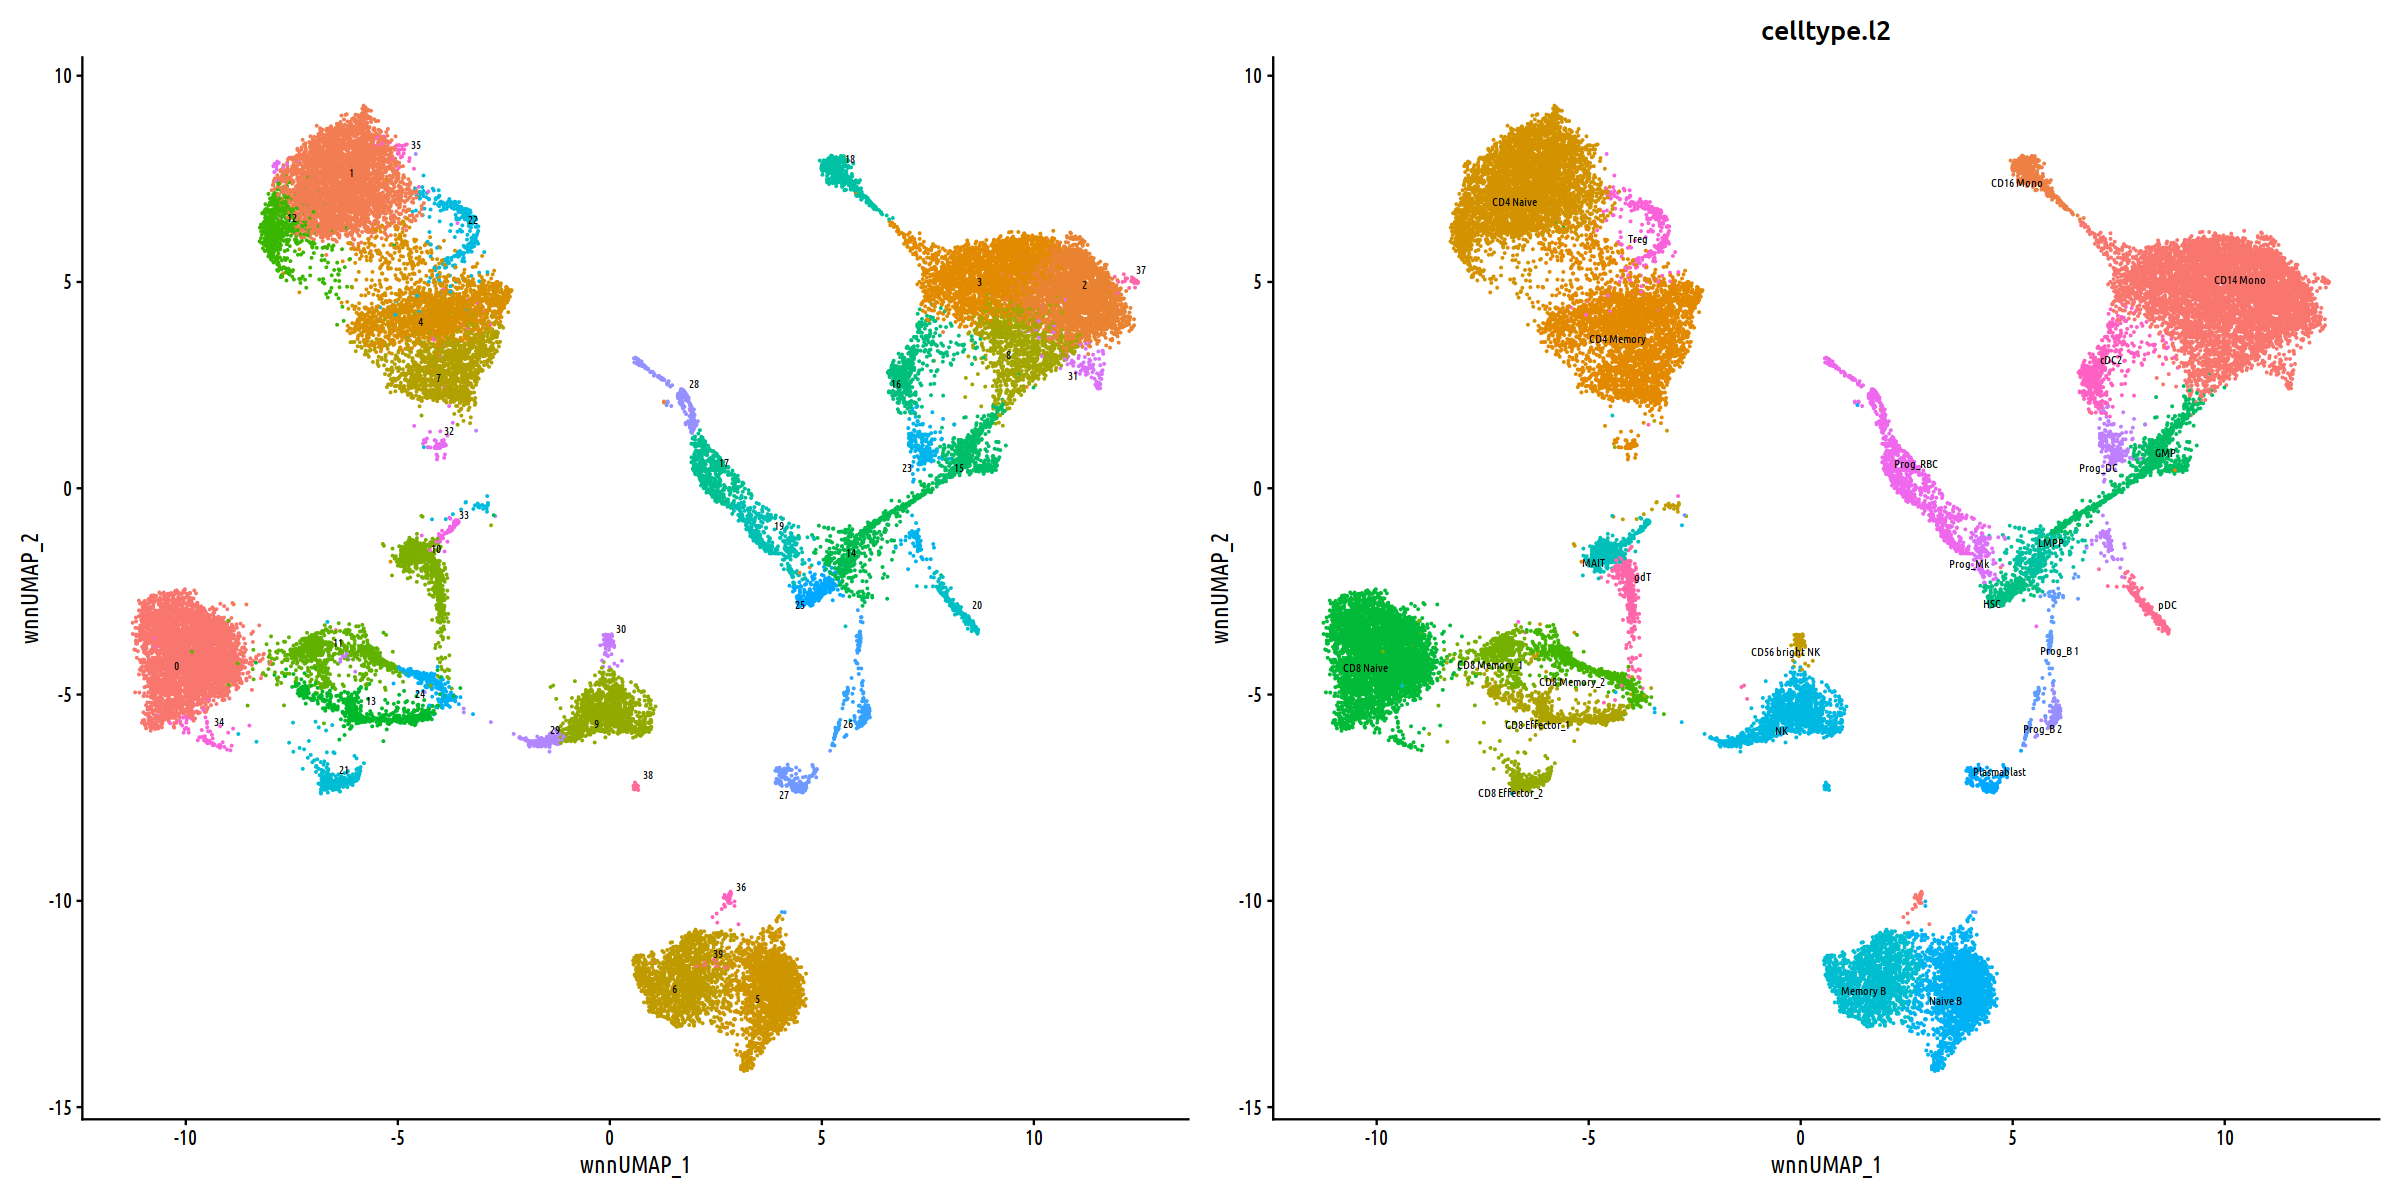

In [10]:
options(repr.plot.width=20, repr.plot.height=10)
p1 <- DimPlot(bm, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(bm, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

We can also compute UMAP visualization based on only the RNA and protein data and compare. We find that the RNA analysis is more informative than the ADT analysis in identifying progenitor states (the ADT panel contains markers for differentiated cells), while the converse is true of T cell states (where the ADT analysis outperforms RNA).

In [11]:
bm <- RunUMAP(bm, reduction = 'pca', dims = 1:30, assay = 'RNA', 
              reduction.name = 'rna.umap', reduction.key = 'rnaUMAP_')
bm <- RunUMAP(bm, reduction = 'apca', dims = 1:18, assay = 'ADT', 
              reduction.name = 'adt.umap', reduction.key = 'adtUMAP_')

12:14:37 UMAP embedding parameters a = 0.9922 b = 1.112

12:14:37 Read 30672 rows and found 30 numeric columns

12:14:37 Using Annoy for neighbor search, n_neighbors = 30

12:14:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:14:42 Writing NN index file to temp file /home/vmuser/.tmp/RtmpZ1kc63/filef706805cc50

12:14:42 Searching Annoy index using 1 thread, search_k = 3000

12:14:59 Annoy recall = 100%

12:14:59 Commencing smooth kNN distance calibration using 1 thread

12:15:01 Initializing from normalized Laplacian + noise

12:15:04 Commencing optimization for 200 epochs, with 1427826 positive edges

12:16:06 Optimization finished

12:16:06 UMAP embedding parameters a = 0.9922 b = 1.112

12:16:06 Read 30672 rows and found 18 numeric columns

12:16:06 Using Anno

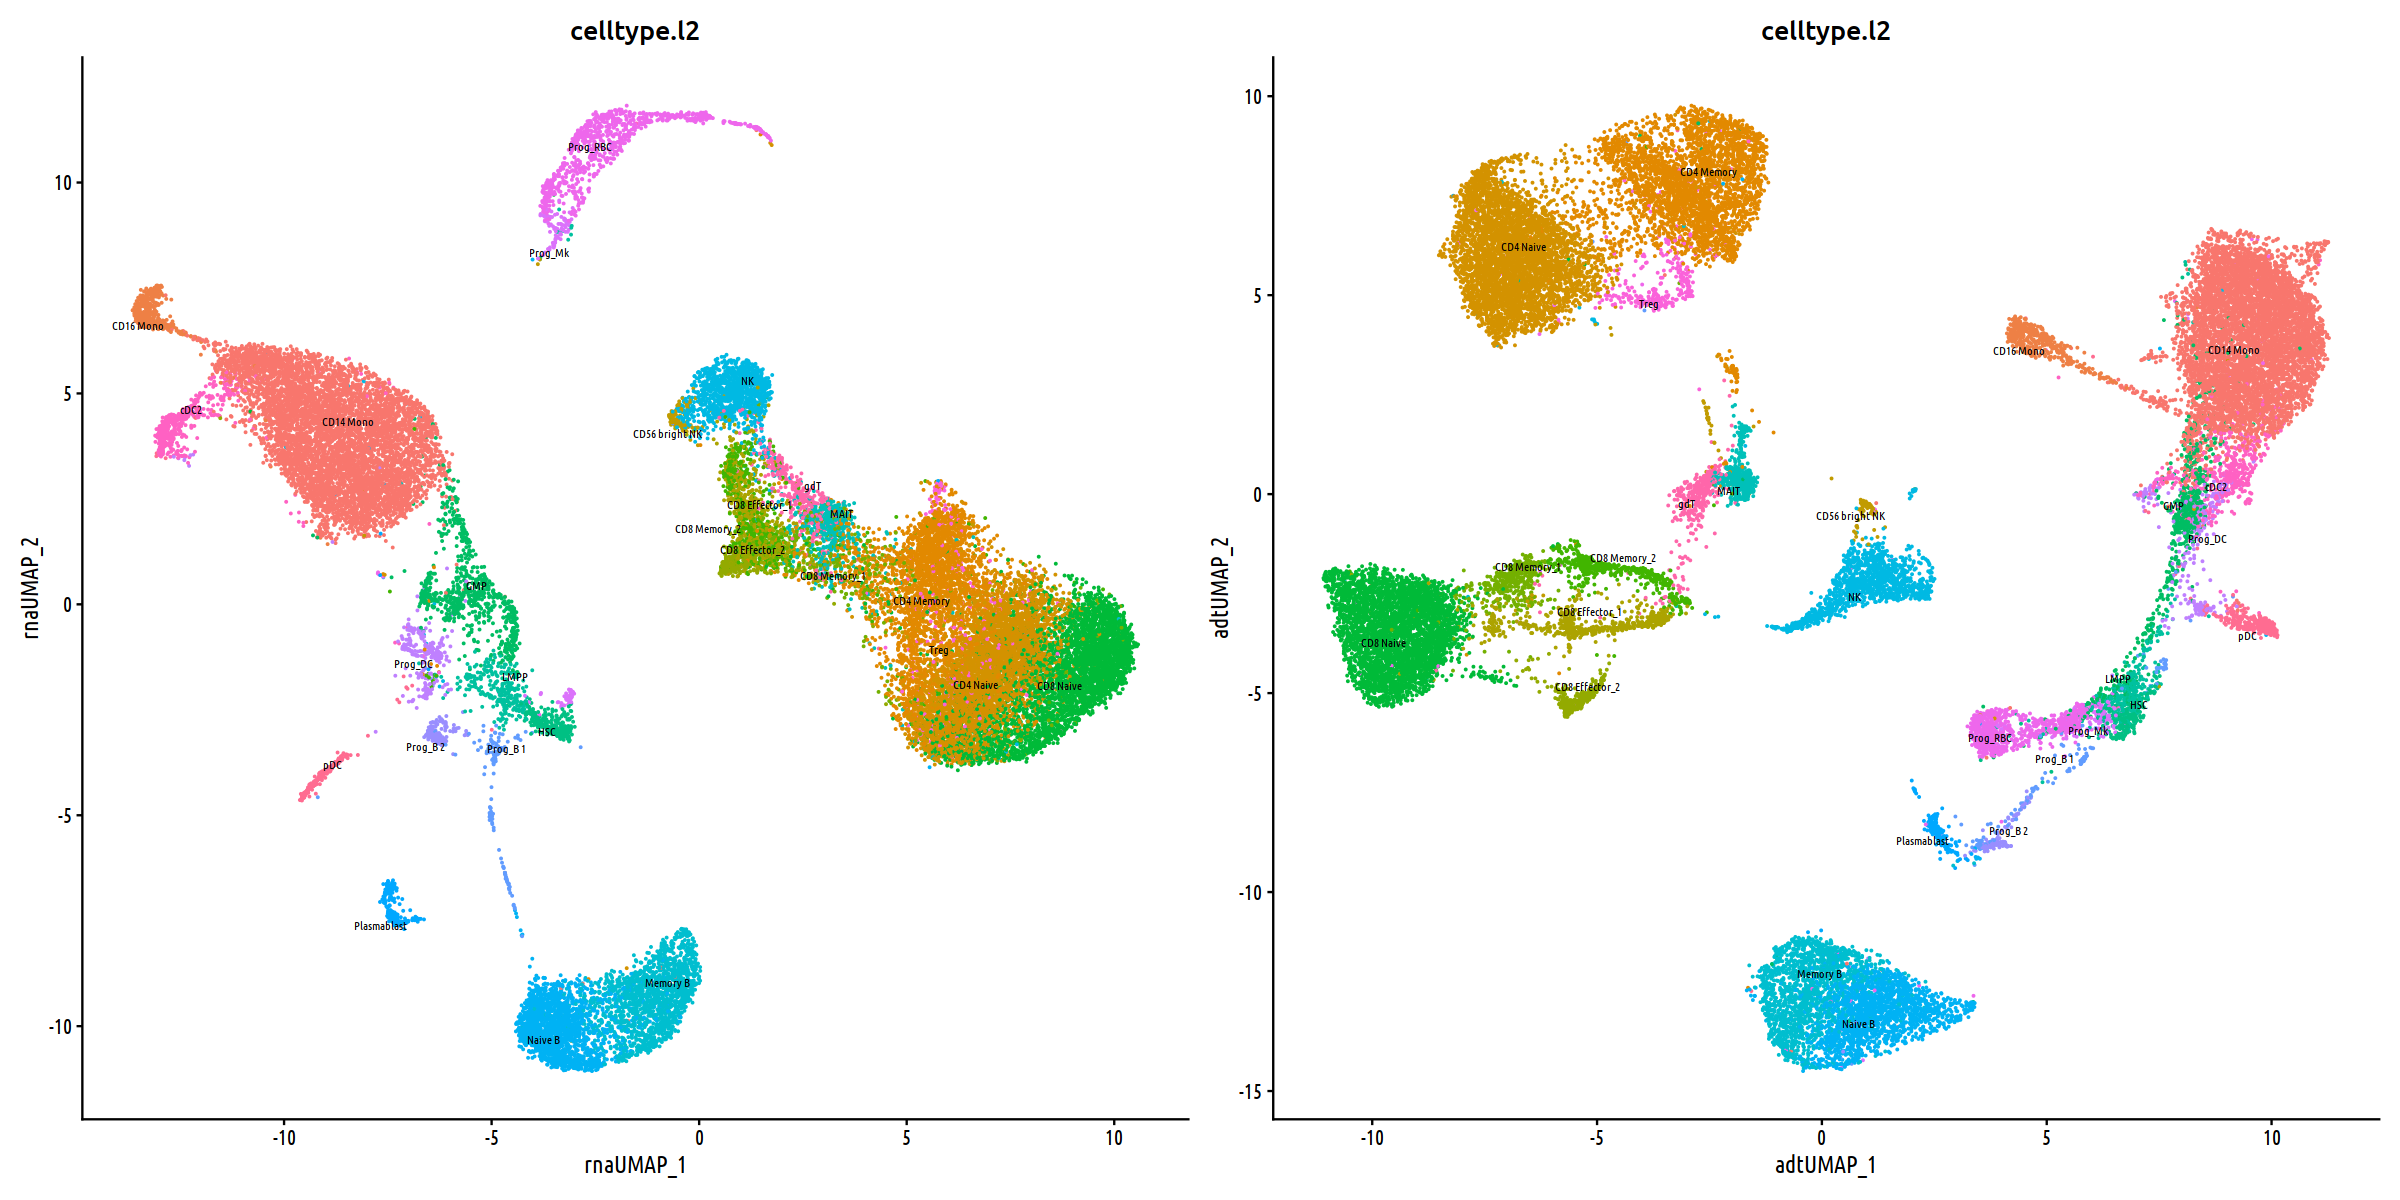

In [12]:
options(repr.plot.width=20, repr.plot.height=10)
p3 <- DimPlot(bm, reduction = 'rna.umap', group.by = 'celltype.l2', label = TRUE, 
              repel = TRUE, label.size = 2.5) + NoLegend()
p4 <- DimPlot(bm, reduction = 'adt.umap', group.by = 'celltype.l2', label = TRUE, 
              repel = TRUE, label.size = 2.5) + NoLegend()
p3 + p4

We can visualize the expression of canonical marker genes and proteins on the multimodal UMAP, which can assist in verifying the provided annotations:

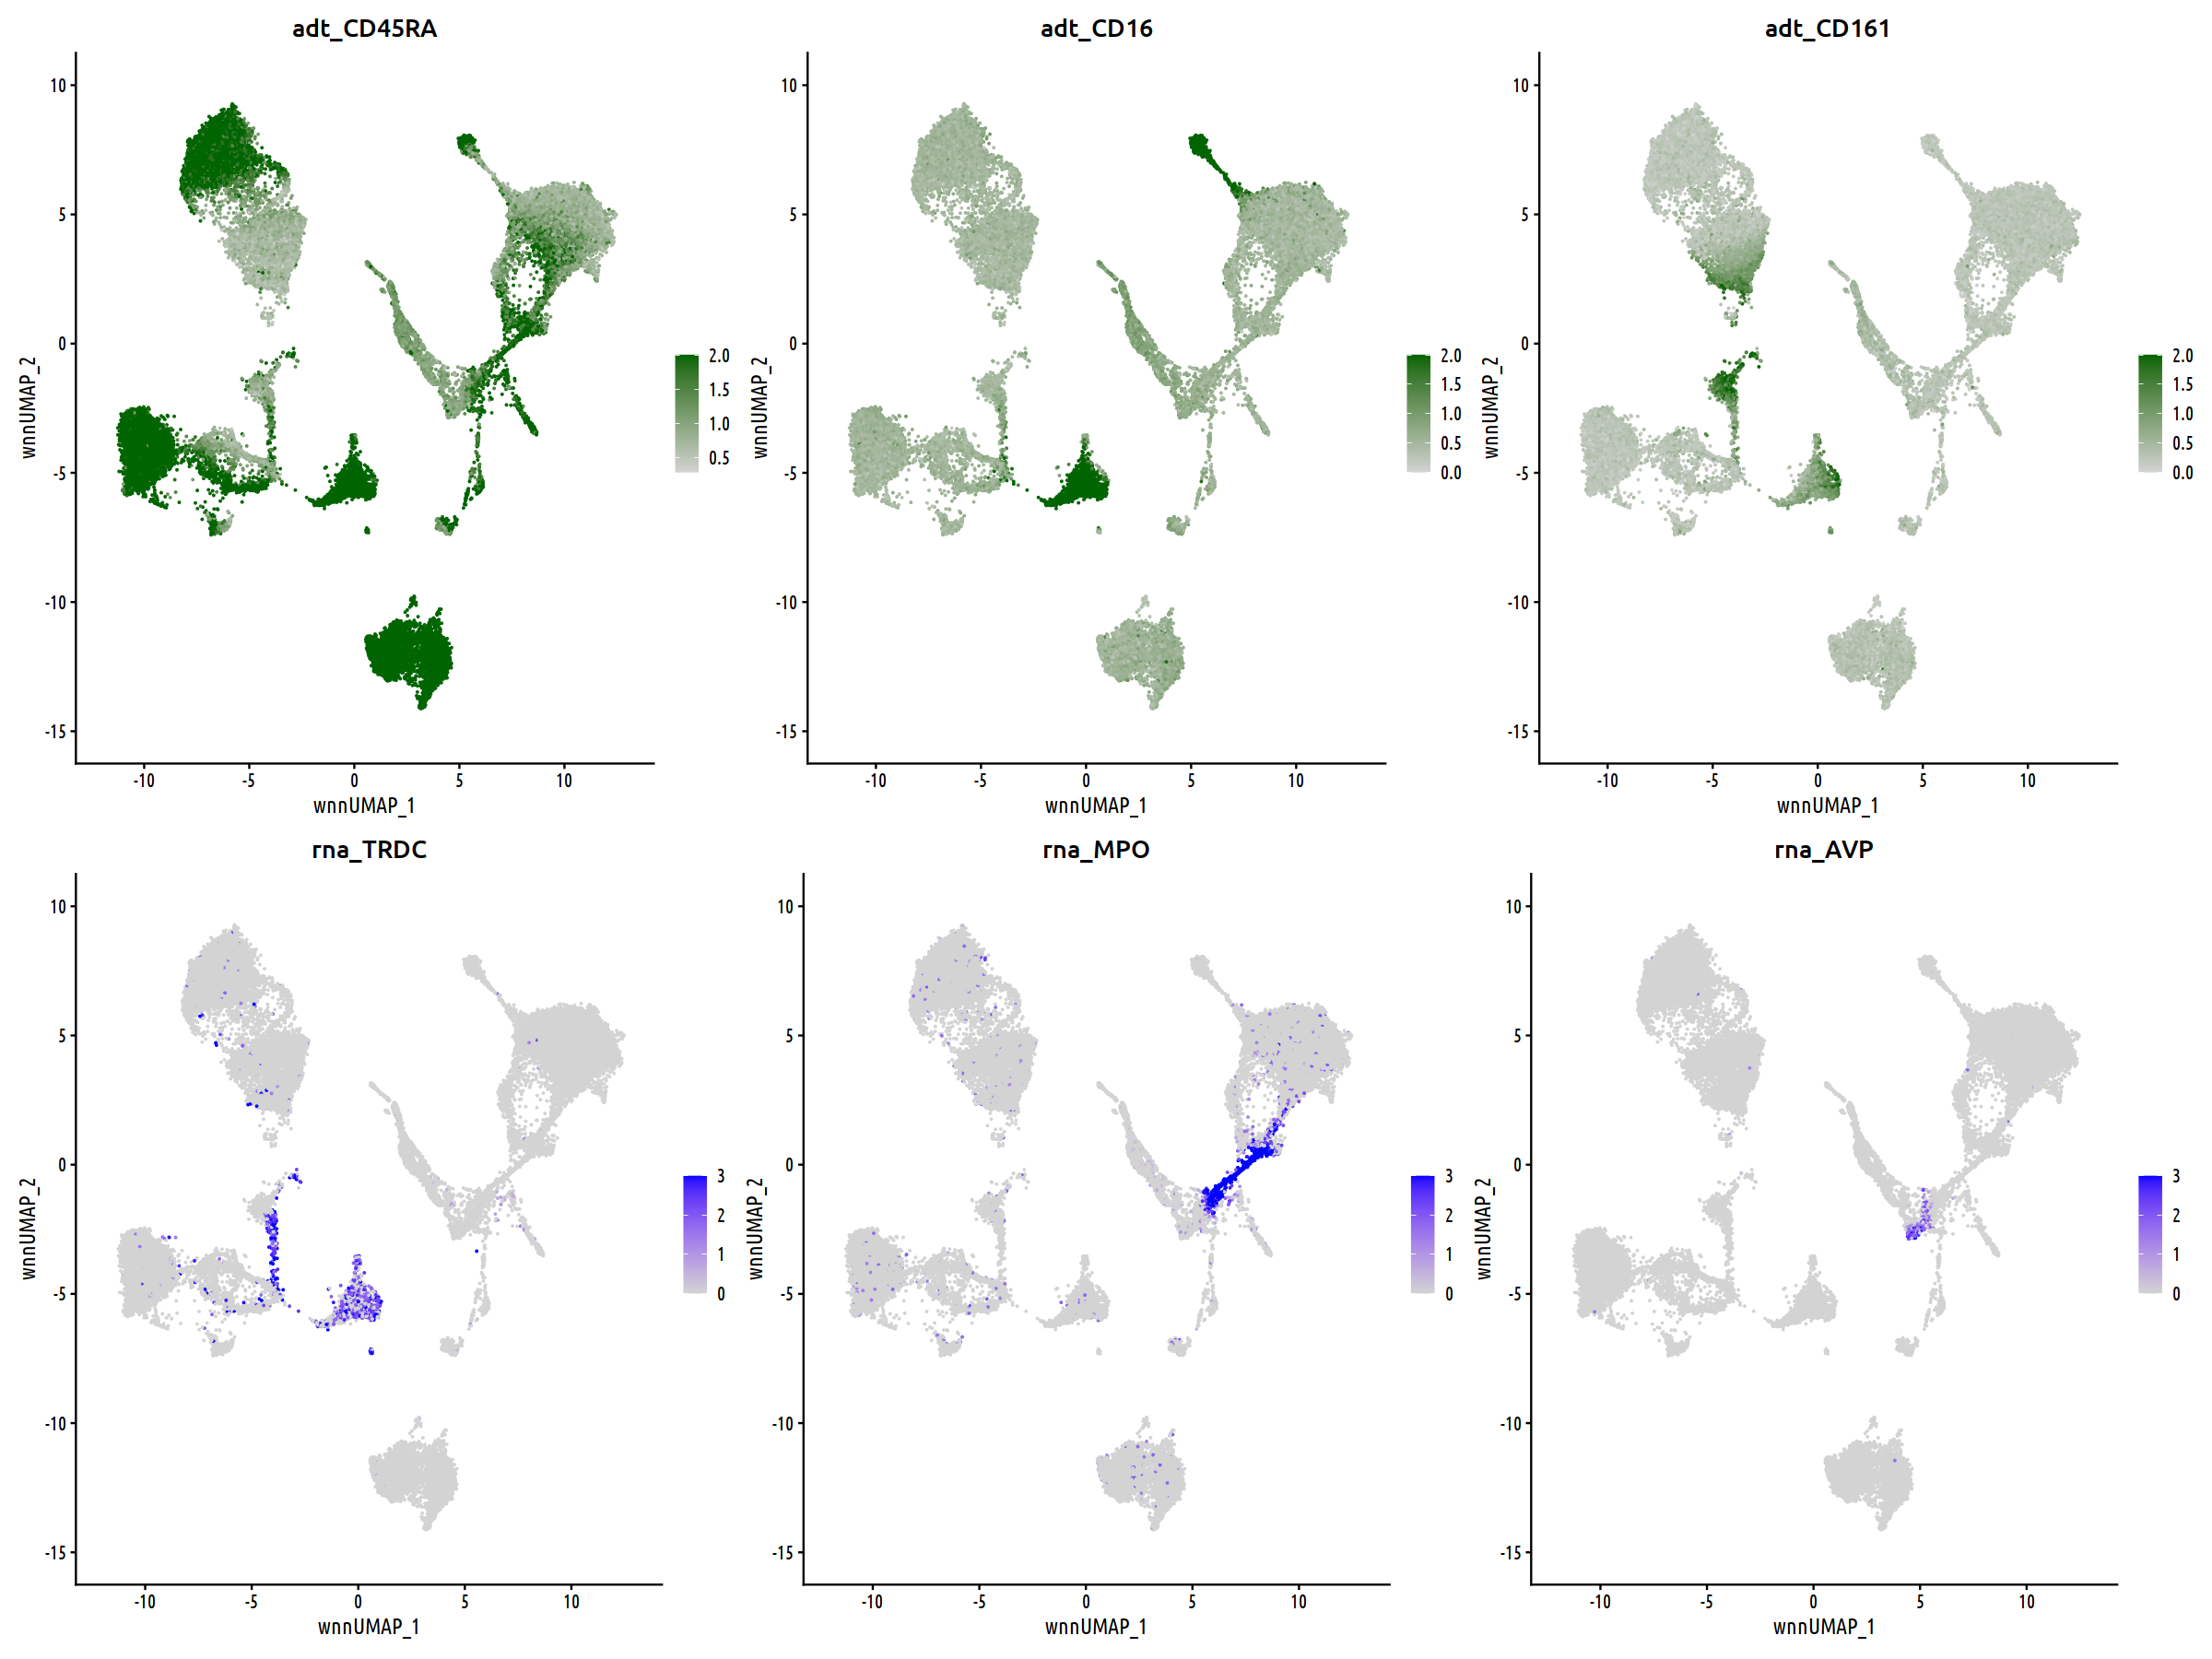

In [13]:
options(repr.plot.width=20, repr.plot.height=15)
p5 <- FeaturePlot(bm, features = c("adt_CD45RA","adt_CD16","adt_CD161"),
                  reduction = 'wnn.umap', max.cutoff = 2, 
                  cols = c("lightgrey","darkgreen"), ncol = 3)
p6 <- FeaturePlot(bm, features = c("rna_TRDC","rna_MPO","rna_AVP"), 
                  reduction = 'wnn.umap', max.cutoff = 3, ncol = 3)
p5 / p6

Finally, we can visualize the modality weights that were learned for each cell. Each of the populations with the highest RNA weights represent progenitor cells, while the populations with the highest protein weights represent T cells. This is in line with our biological expectations, as the antibody panel does not contain markers that can distinguish between different progenitor populations.

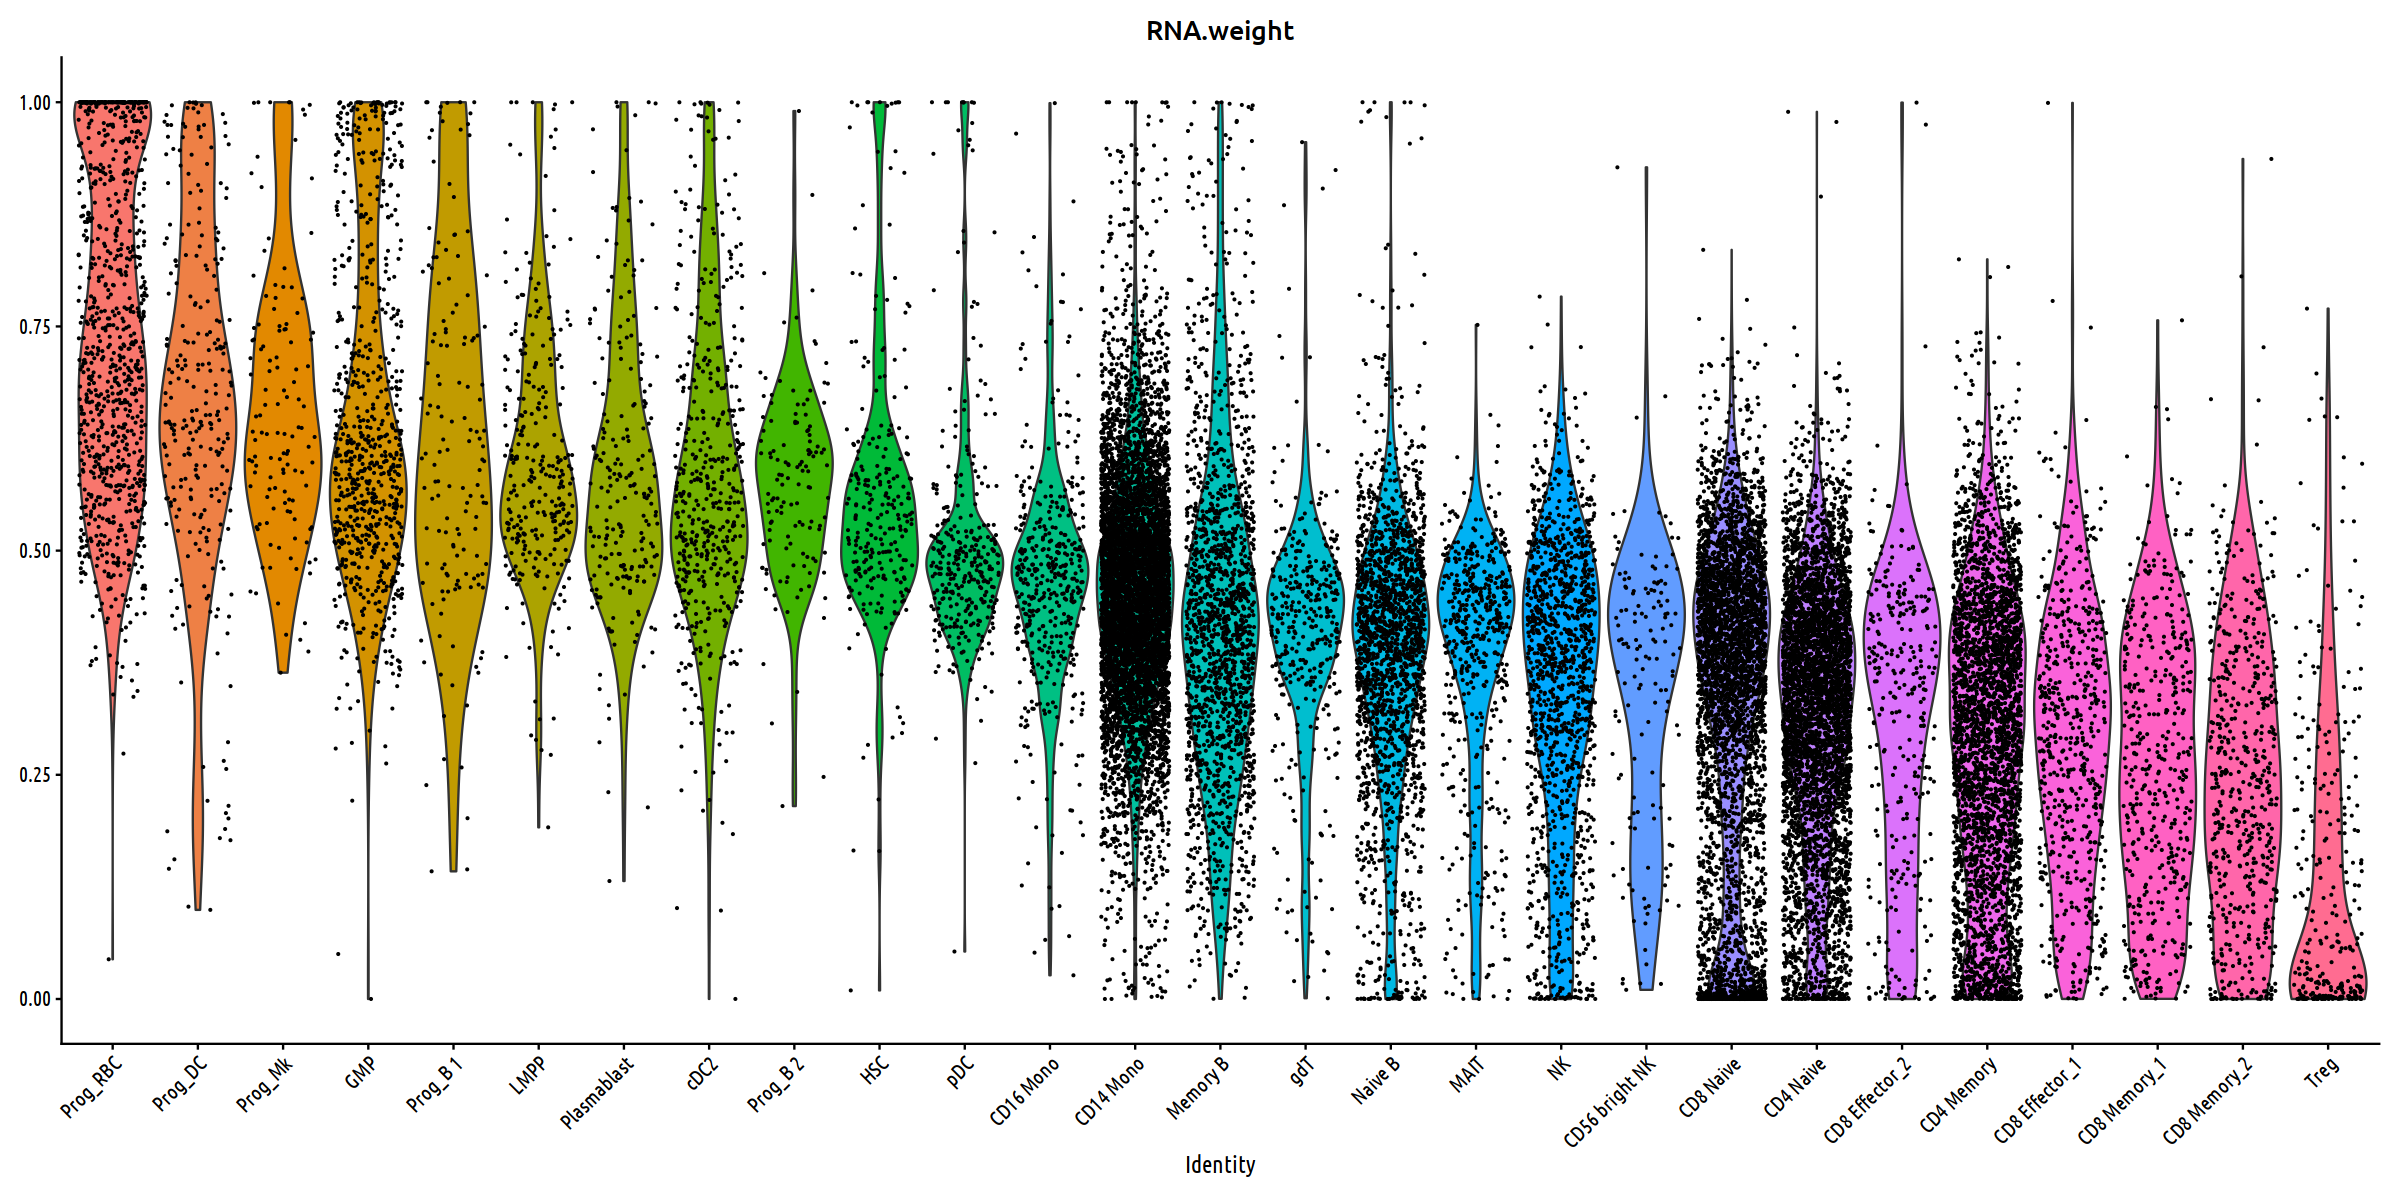

In [14]:
options(repr.plot.width=20, repr.plot.height=10)
VlnPlot(bm, features = "RNA.weight", group.by = 'celltype.l2', sort = TRUE, pt.size = 0.1) +
  NoLegend()